# 라이브러리

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from glob import glob
from tqdm import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# from sklearn.neighbors import KNeighborsRegressor # KNN

In [3]:
def sorted_list(path):
    tmplist = glob.glob(path)
    tmplist.sort()
    return tmplist

def read_csv(path):
    df = pd.read_csv(path)
    return df

def load_npy(path): 
    npy = np.load(path)
    return npy

def show_data(npy):
    num_channel = npy.shape[-1]
    plt.figure(figsize=(3*num_channel, 5))
    for channel in range(num_channel):
        tmpimg = npy[:, :, channel]
        plt.subplot(1, num_channel, channel+1)
        plt.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

# TPU 설정

### TPU 초기화 및 설정

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.77.218.26:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.77.218.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.218.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# 구글드라이브 연결

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/dacon/위성 영상을 활용한 북극 해빙 예측 AI 경진대회/'

# CSV 데이터 불러오기

In [7]:
df = pd.read_csv(path + 'data_v2/train_v2.csv')
df.tail()

,month,file_nm
489,2019-08,201908.npy
490,2019-09,201909.npy
491,2019-10,201910.npy
492,2019-11,201911.npy
493,2019-12,201912.npy


In [8]:
train_path = sorted(glob(path + 'data_v2/train_data_v2/*.npy'))
train_path = train_path[-30*12:]

In [9]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [00:01<00:00, 215.84it/s]


# 시각화

- 각 파일(*.npy)은
- 해빙 농도(0~250), 북극점(위성 관측 불가 영역), 해안선 마스크, 육지 마스크, 결측값
- 총 5개의 채널로 구성

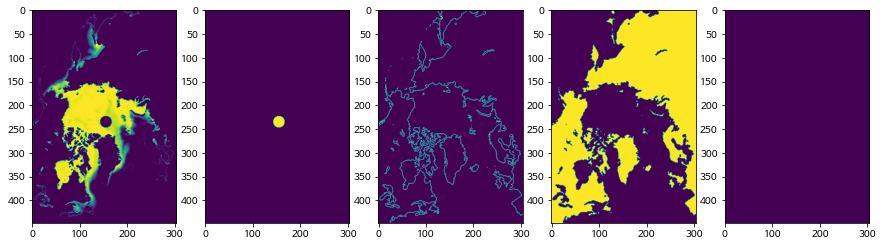

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])

# EDA(탐색적 자료 분석)

In [11]:
filenames = os.listdir(path + 'data_v2/train_data_v2/')
filenames.sort()

In [12]:
data=[]

for filename in tqdm(filenames):
    data.append(
        np.load(f"{path}data_v2/train_data_v2/{filename}")
    )
data = np.array(data)

100%|██████████| 494/494 [00:01<00:00, 272.22it/s]


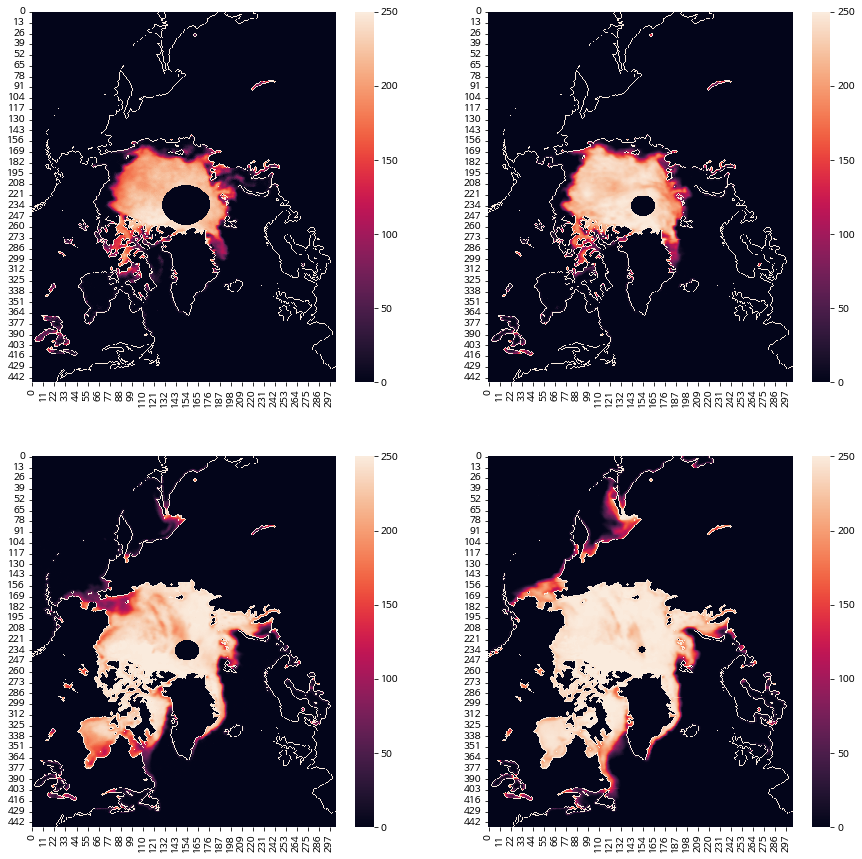

In [13]:
figure, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(15, 15)
sns.heatmap(data[105][:,:,0]+ (data[105][:,:,2])*250, ax=ax1)
sns.heatmap(data[106][:,:,0]+ (data[106][:,:,2])*250, ax=ax2)
sns.heatmap(data[349][:,:,0]+ (data[349][:,:,2])*250, ax=ax3)
sns.heatmap(data[350][:,:,0]+ (data[350][:,:,2])*250, ax=ax4)

- 시간이 갈수록 측정 불가능한 북극점의 영역이 좁아지는 것을 볼 수 있다.
- 위성이 좋아져 좀 더 많은 관측이 가능해지기 때문으로 보임.
- 이미지 데이터는 250이 최댓값이고, 값 37.5(15%) 가 F1 Threshold 이기 때문에 250 이면 100%해빙 이라고 볼 수 있다.

### 해안선 vs 육지

1


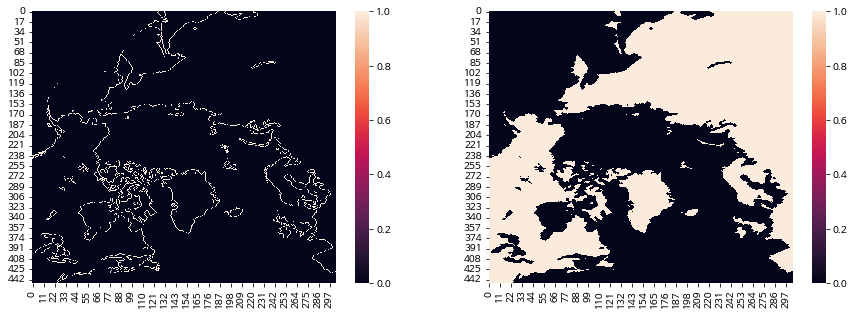

In [14]:
print((data[0][:,:,2] + data[0][:,:,3]).max())
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15, 5)
sns.heatmap(data[0][:,:,2], ax=ax1)
sns.heatmap(data[0][:,:,3], ax=ax2)

- 해안선 마스크와 육지 마스크 비교
- 겹치는 부분이 없다. 
- 두 데이터는 모두 0, 1의 값이다.
- 두 데이터를 더해도 최댓값이 1인 것으로 보아, 육지로 표시된 부분의 테두리를 해안선으로 표시했다고 추정할 수 있다.

# 해빙농도 합의 변화


In [15]:
# 해빙 / 북극점 / 해안 / 지면 / 결측치 데이터 분리
thaw = pd.DataFrame()
thaw_pluse_pole = pd.DataFrame() 
train = pd.read_csv(path + 'data_v2/train_v2_01.csv')
data = np.load(path + 'data_v2/train_data_v2/' + train['file_nm'][2])

In [16]:
total_data = []

 # 80년 01월부터 연단위 데이터 추출 198001.npy
for iter in range(0, train.shape[0]):
    data = np.load(path + 'data_v2/train_data_v2/' + train['file_nm'][iter]) 
    total_data.append(data)
    thaw = pd.concat([thaw, pd.DataFrame(data[:, :, 0].reshape(1, -1))], ignore_index = True)
    thaw_pluse_pole = pd.concat([thaw_pluse_pole, pd.DataFrame(data[:, :, 1].reshape(1, -1))], ignore_index = True) 

total_data = np.array(total_data)    

In [17]:
thaw_sum = []
thaw_sum = np.array(thaw.sum(axis=1))

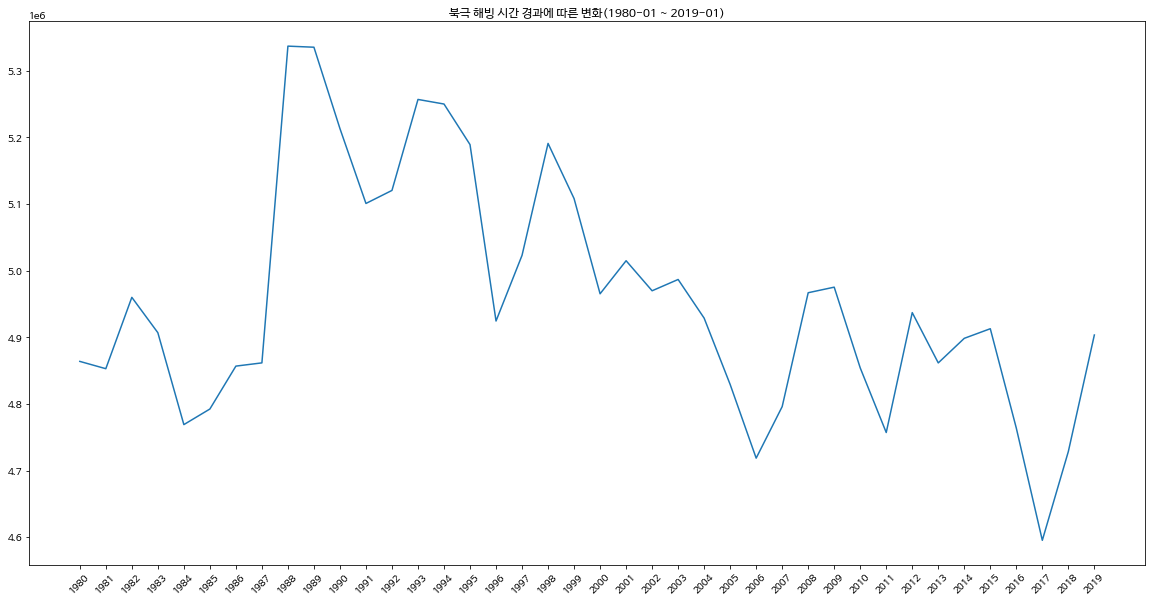

In [18]:
plt.figure(figsize = (20,10))
plt.title('북극 해빙 시간 경과에 따른 변화(1980-01 ~ 2019-01)')
plt.plot(train['month'], thaw_sum)
plt.xticks(range(1980, 2020), rotation=45)
plt.show()

# 계절성 제거 후 변화 확인

In [19]:
def moving_average_forecast(series, window_size):
  """마지막 몇 개 값의 평균을 예측"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

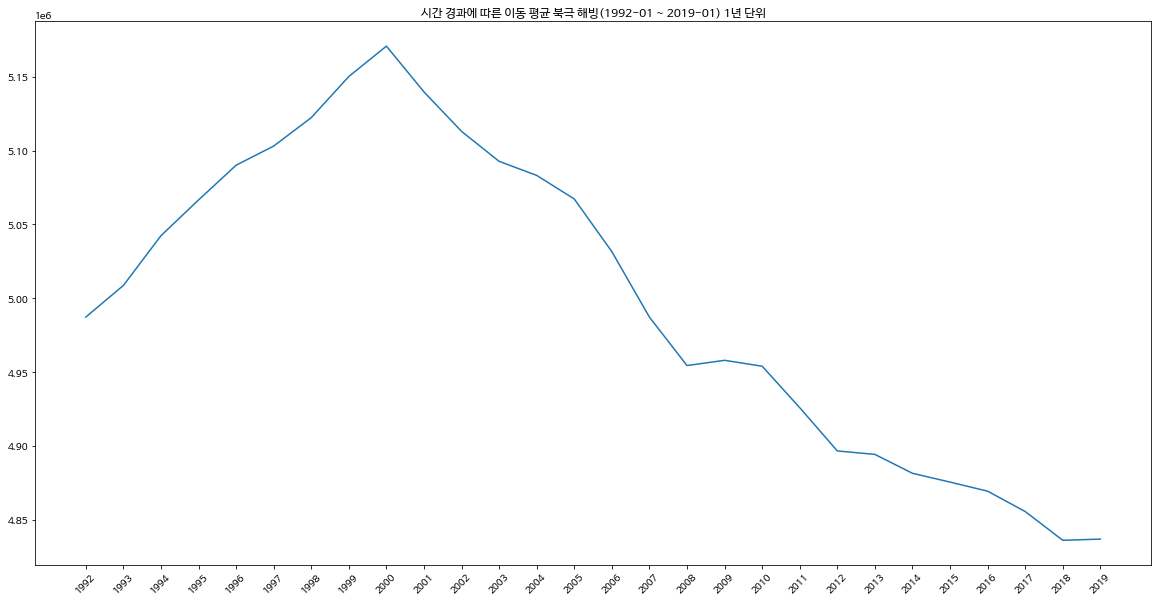

In [31]:
moving_avg = moving_average_forecast(thaw_sum, 12)

plt.figure(figsize = (20,10))
plt.title('시간 경과에 따른 이동 평균 북극 해빙(1992-01 ~ 2019-01) 1년 단위')
plt.plot(train['month'][12:], moving_avg)
plt.xticks(range(1992, 2020), rotation=45)
plt.show()

# 빙하의 감소추세가 잘 보이지 않는 이유

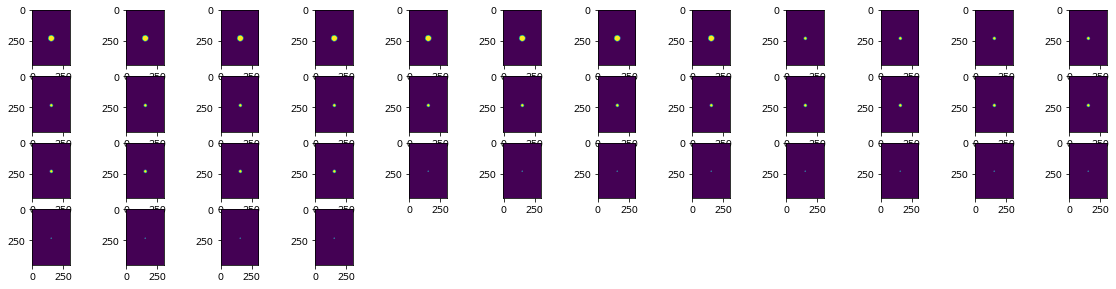

In [21]:
fig = plt.figure(figsize = (20, 50))
for iter in range(0, total_data.shape[0]):
    fig.add_subplot(41, 12, iter+1)
    plt.imshow(total_data[iter, :, :, 1])
fig.show()

# 북극점(위성 관측 불가 영역)을 결빙도 250으로 채워서 해빙 데이터에 더함

In [22]:
thaw_pluse_pole = total_data[:,:,:,0] + total_data[:,:,:,1] * 250

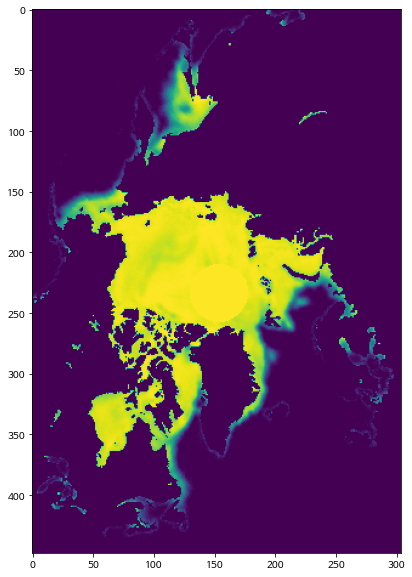

In [23]:
plt.figure(figsize =  (10, 10))  
plt.imshow(thaw_pluse_pole[0, :, :])
fig.show()

In [24]:
thaw_pluse_pole = thaw_pluse_pole.reshape(thaw_pluse_pole.shape[0], thaw_pluse_pole.shape[1] * thaw_pluse_pole.shape[2])

In [25]:
thaw_pluse_pole.shape
thaw_pluse_pole_sum = []
thaw_pluse_pole_sum = np.array(thaw_pluse_pole.sum(axis=1))

# 북극점(위성 관측 불가 영역)을 결빙도 250으로 전부 채운 후의 결빙도 합의 그래프

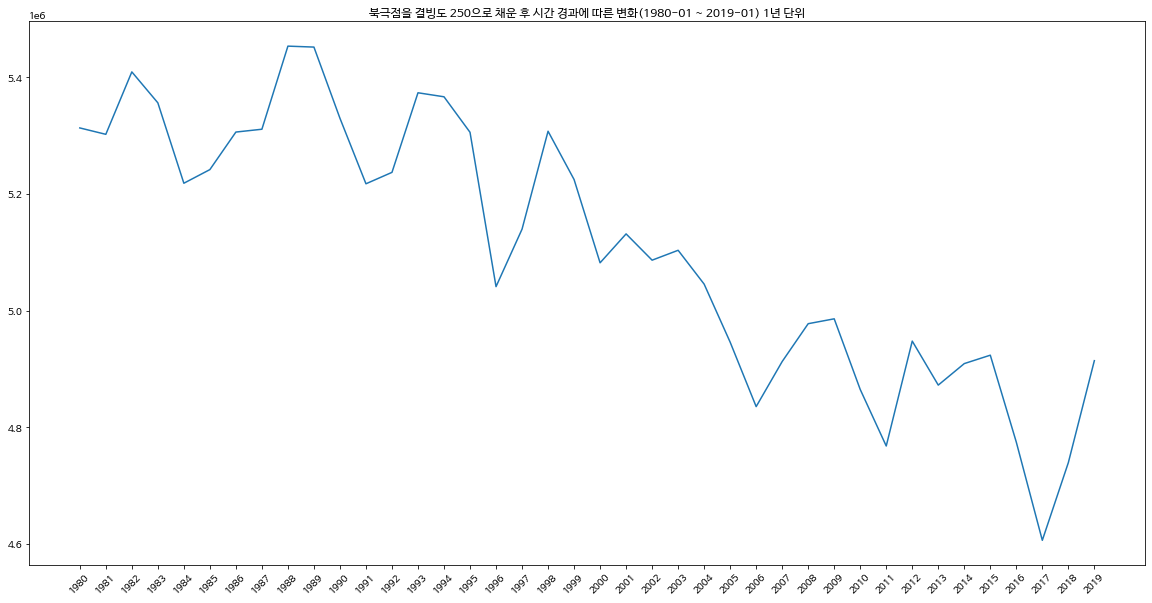

In [26]:
plt.figure(figsize = (20,10))
plt.title('북극점을 결빙도 250으로 채운 후 시간 경과에 따른 변화(1980-01 ~ 2019-01) 1년 단위')
plt.plot(train['month'], thaw_pluse_pole_sum)
plt.xticks(range(1980, 2020), rotation=45)
plt.show()

# 북극점(위성 관측 불가 영역)을 채운 후 결빙도 합의 12개월 이동평균 그래프

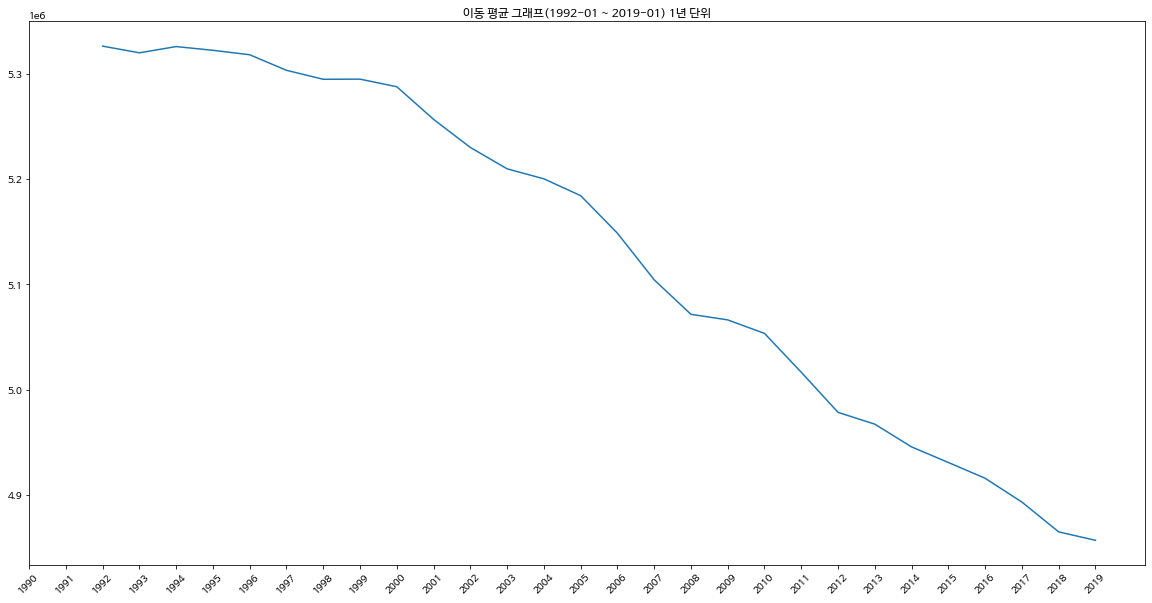

In [27]:
moving_avg_plus_pole = moving_average_forecast(thaw_pluse_pole_sum, 12)

plt.figure(figsize = (20,10))
plt.title('이동 평균 그래프(1992-01 ~ 2019-01) 1년 단위')
plt.plot(train['month'][12:], moving_avg_plus_pole)
plt.xticks(range(1990, 2020), rotation=45)
plt.show()

# 한국 기온

In [28]:
korea_temp = pd.read_csv(path + '기온/1980_2019년 전국 평균 기온.csv', encoding='cp949')
korea_temp.tail()

,년,지점,평균기온(℃),최저기온(℃),최고기온(℃)
35,2015,전국,13.1,8.3,18.7
36,2016,전국,13.4,8.7,18.8
37,2017,전국,12.8,7.7,18.5
38,2018,전국,12.8,7.8,18.4
39,2019,전국,13.3,8.3,19.0


In [29]:
korea_temp = korea_temp[['년', '평균기온(℃)']]
korea_temp = korea_temp.set_index('년')
korea_temp.tail()

,평균기온(℃)
년,
2015,13.1
2016,13.4
2017,12.8
2018,12.8
2019,13.3


### 시각화

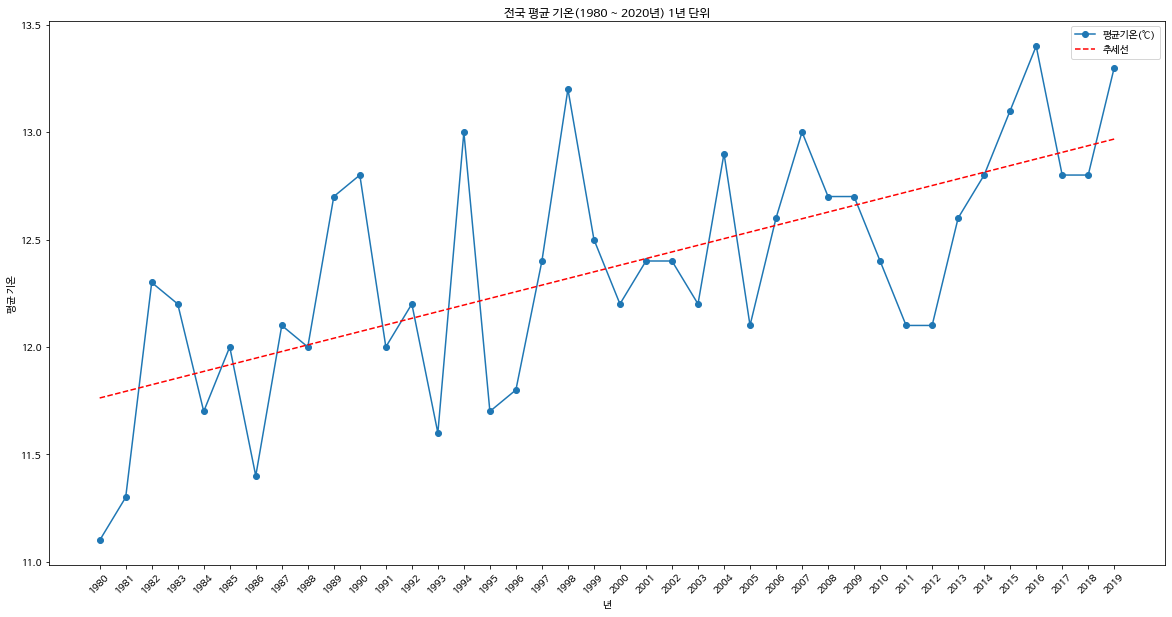

In [30]:
x=korea_temp.index
y=korea_temp['평균기온(℃)']
z=np.polyfit(x, y, 1)
p=np.poly1d(z)

plt.figure(figsize=(20,10))

plt.plot(x, y, label='평균기온(℃)', marker='o')
plt.plot(x, p(x), 'r--', label='추세선')
plt.title('전국 평균 기온(1980 ~ 2020년) 1년 단위')
plt.xlabel('년')
plt.ylabel('평균 기온')
plt.xticks(range(1980, 2020), rotation=45)

plt.legend()
plt.show()

# 기상청 북극해방감시시스템

http://seaice.kma.go.kr/cmm/main/mainPage.do

### 해빙 면적 및 해빙 표면거칠기(1989.01.01 ~ 01.31)
- 분홍색 30년 평균(1988년 ~ 2017년)
- 초록색 10년 평균(1988년 ~ 1997년)

<img src = "https://drive.google.com/uc?id=1al9q6Yb8lipednPW3FFLhwO_M6Q4Mqsv">

### 최근 해빙 변화 근황

<img src = "https://drive.google.com/uc?id=1WilPtAo6f6FR-9iRmVRhvdZrUqUAm0OK">

### 해빙 전방 2021년 2월
<img src = "https://drive.google.com/uc?id=1bed7Vsa3k-U_aNLS79PZibircEP5w7Zg">